#### **Density Profile Comparisons**:

Notebook for calculation of 2D and 3D density profiles of galaxies, dark matter, and gas.

In [2]:
import numpy as np
import illustris_python as il
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
import seaborn as sns
import h5py
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology as colossus_cosmo
from colossus.halo import concentration
import emcee
import scipy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

sns.set(style = "ticks")
pi = np.pi

from IPython.core.display import display, HTML

%config IPCompleter.greedy = True
%config InlineBackend.figure_format ='retina'

basePath = '../Splashback-Research/TNG-300_3/outputs/'
basePath_dark = '../Splashback-Research/TNG-300_3_Dark/outputs/'


# basePath = '../Splashback-Research/TNG-100_3/outputs/'
# basePath_dark = '../Splashback-Research/TNG-100_3_Dark/outputs/'

snap_dir_g = basePath+'snapdir_066/snap_066.0.hdf5'
snap_dir_dark = basePath_dark+'snapdir_066/snap_066.0.hdf5'

snap_dir_g = basePath+'snapdir_099/snap_099.0.hdf5'
snap_dir_dark = basePath_dark+'snapdir_099/snap_099.0.hdf5'

matching_cat_path = basePath+'subhalo_matching_to_dark.hdf5'

snapshot_ind = 99

# Load header file and halo group catalog
header = il.groupcat.loadHeader(basePath, snapshot_ind)
header_dark = il.groupcat.loadHeader(basePath_dark, snapshot_ind)

halo_grp_fields = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_M_Mean200', 
                   'Group_R_Crit200', 'Group_R_Mean200', 'GroupFirstSub']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields=halo_grp_fields)
halo_grp['has_gas'] = True

header_dark = il.groupcat.loadHeader(basePath_dark, snapshot_ind)
halo_grp_fields_dark = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_M_Mean200', 
                        'Group_R_Crit200', 'Group_R_Mean200', 'GroupFirstSub']
halo_grp_dark = il.groupcat.loadHalos(basePath_dark, snapshot_ind, fields=halo_grp_fields_dark)
halo_grp_dark['has_gas'] = False

# Obtain basic cosmological info and obtain conversion factors
redshift = header['Redshift']
H = cosmo.H(redshift)
H0 = cosmo.H(0)
h = H0.value/100
cosmo_col = colossus_cosmo.setCosmology('planck15');

# Define box boundary vector in Mpc (for period bcs)
boxsize = header['BoxSize'] # kpc/h
box_bounds = boxsize*np.ones(3)/1000

# Get DM Particle mass
with h5py.File(snap_dir_dark) as f:
    snap_dark = dict(f['Header'].attrs.items())

with h5py.File(snap_dir_g) as f:
    snap_g = dict(f['Header'].attrs.items())
    
dm_part_mass_dark = snap_dark['MassTable'][1]*10**10/h # Mass in solar mass
dm_part_mass = snap_g['MassTable'][1]*10**10/h

# Get subhalo matching catalog
with h5py.File(matching_cat_path) as f:
    subhalo_match = f['Snapshot_'+str(snapshot_ind)]['SubhaloIndexDark_LHaloTree'][()]

# Compute subhalo matching catalog index by dark files
subhalo_match_dark = -1*np.ones(header_dark['Nsubgroups_Total'], dtype=int)
subhalo_match_dark[subhalo_match[np.where(subhalo_match != -1)]] = np.argwhere(subhalo_match != -1).flatten()

print("Snapshot Num: "+str(snapshot_ind))
print("Snapshot Boxsize: "+str(boxsize)+" [kpc/h]")
print("Snapshot Redshift: "+str(redshift))
print("Total Number of Halos in Snapshot: "+str(halo_grp['count']))

Snapshot Num: 99
Snapshot Boxsize: 205000.0 [kpc/h]
Snapshot Redshift: 2.220446049250313e-16
Total Number of Halos in Snapshot: 377342


#### **Pick Subset of Halos to Analyze**:

Specify a subset of halos from TNG-100_3 and TNG-100_3_Dark catalogs to perform analysis on.

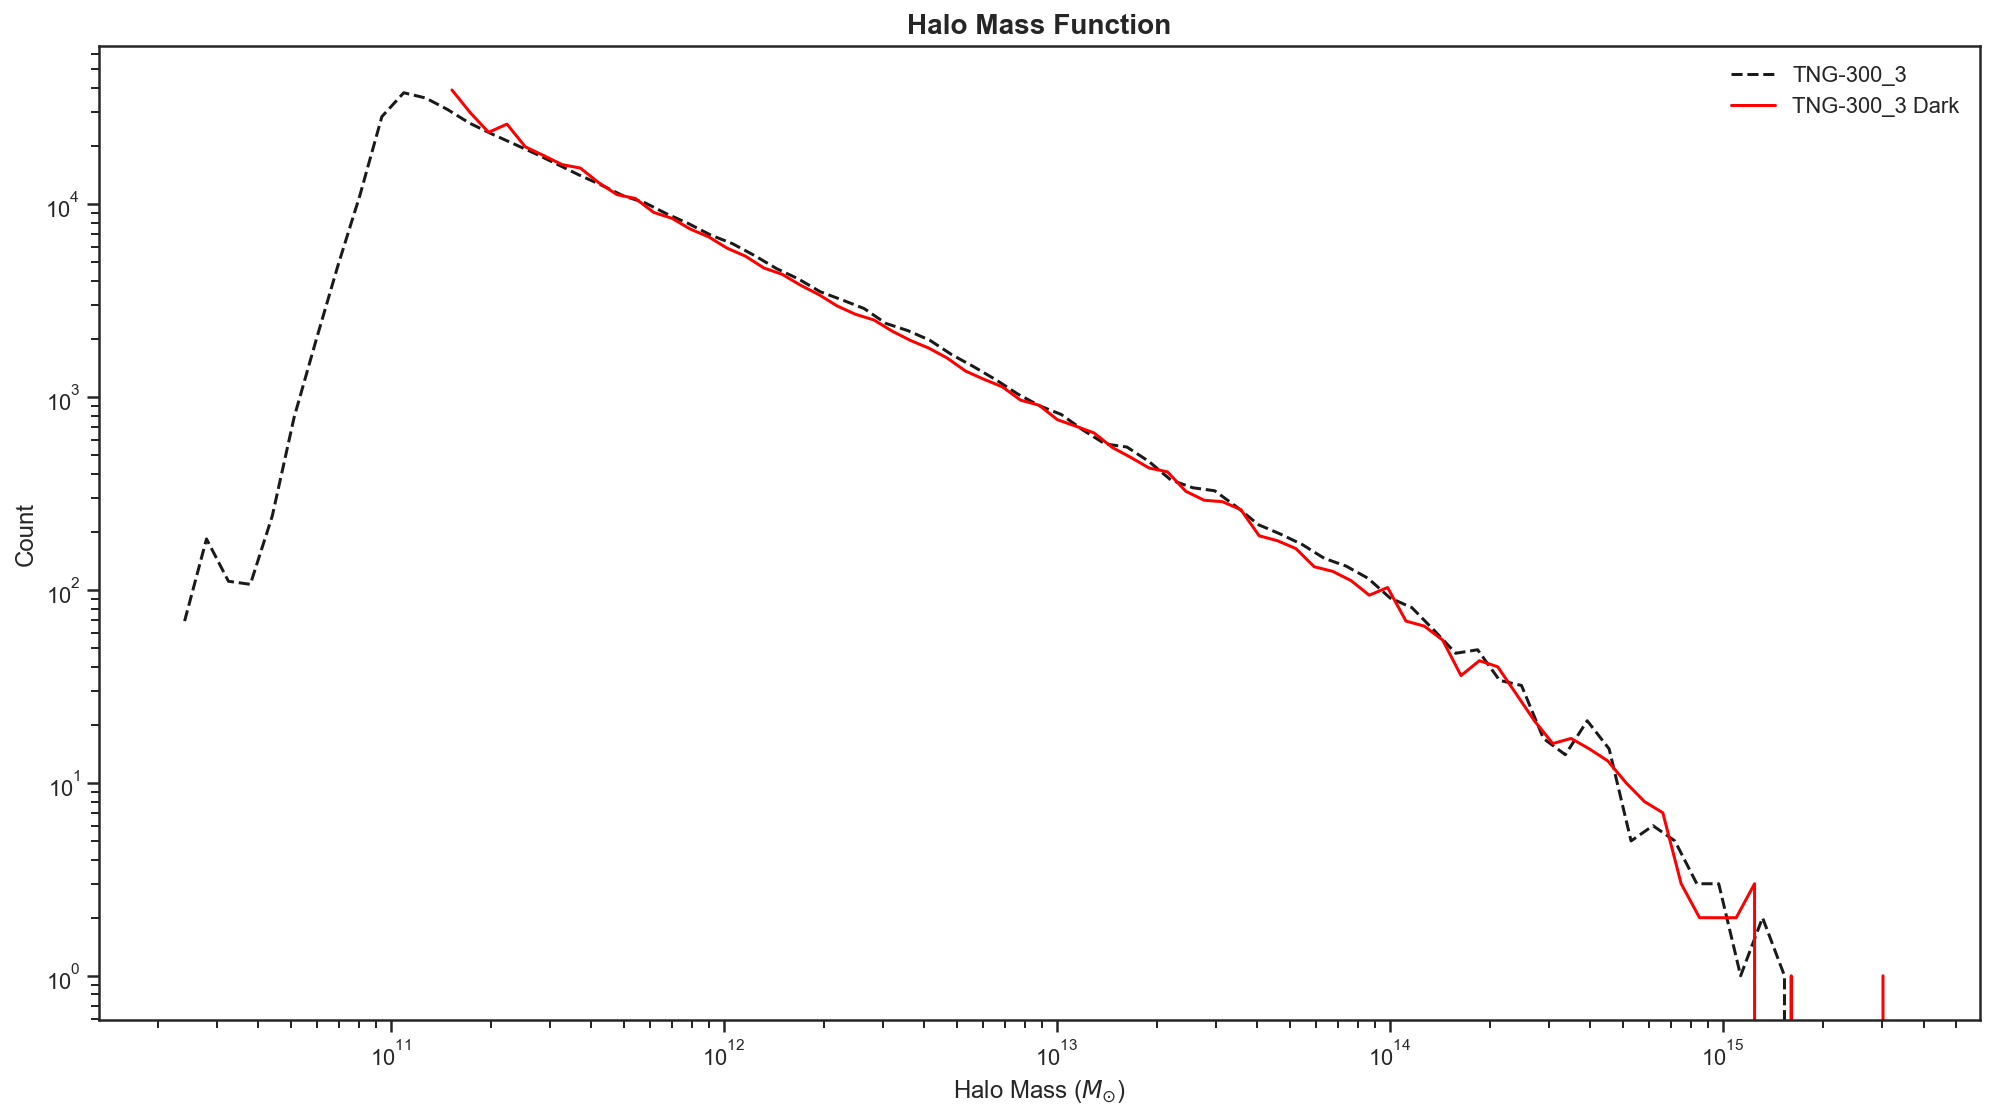

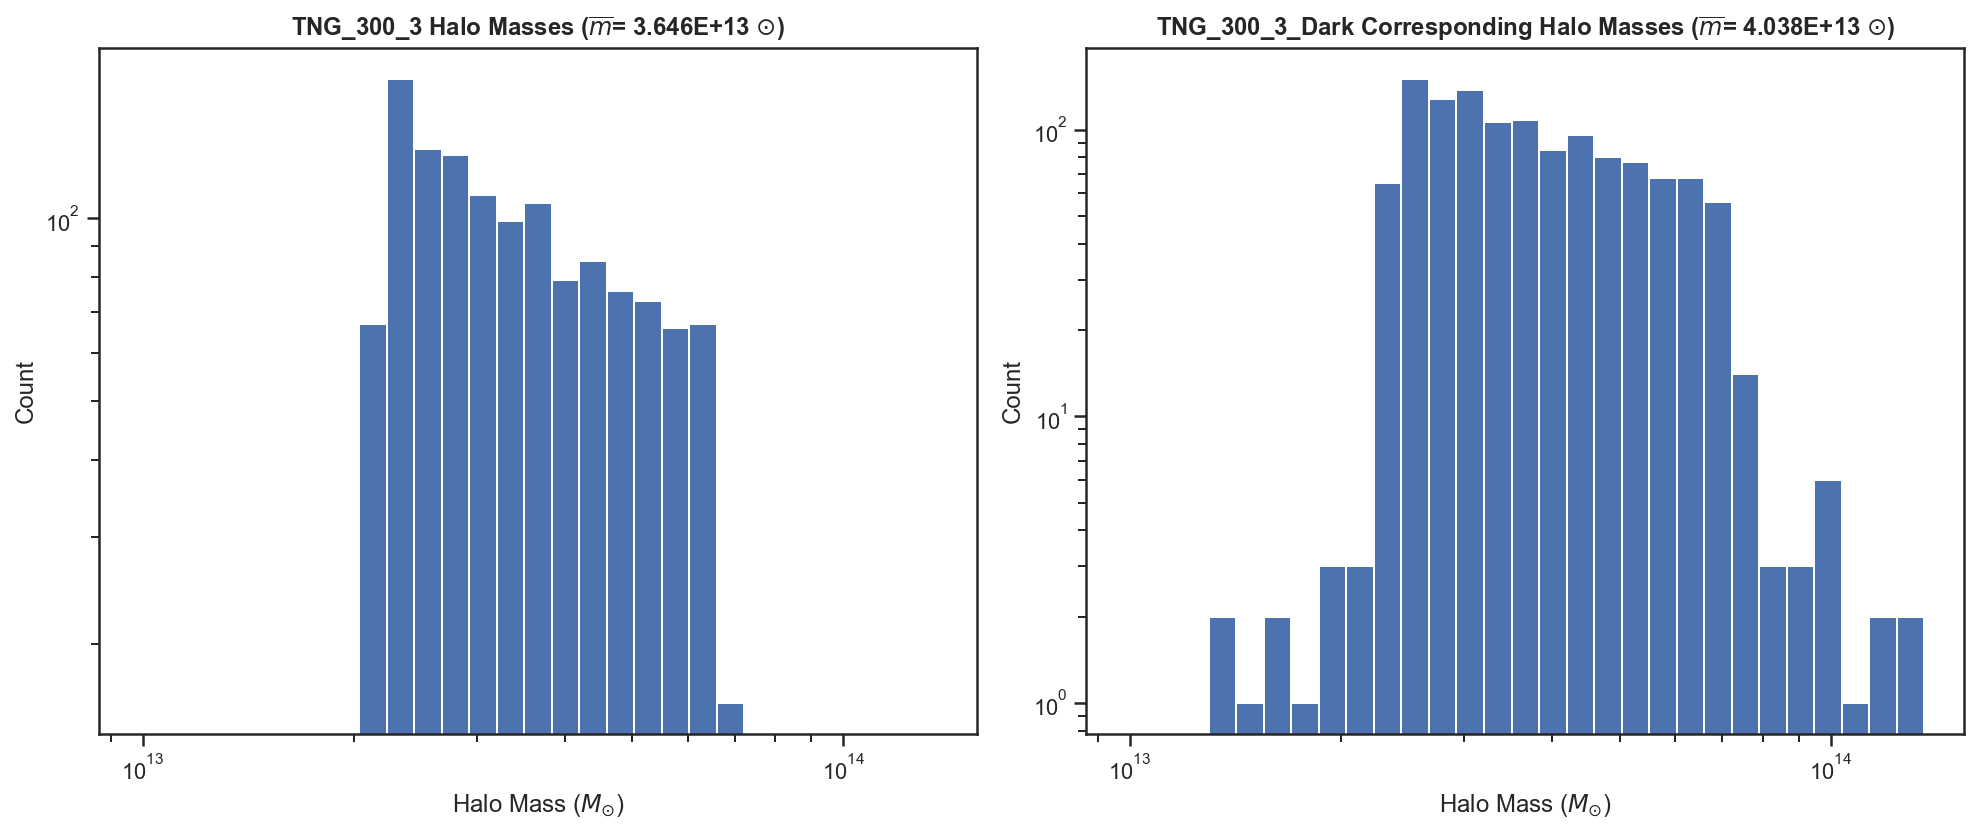

In [3]:
# Compute halo mass function for the two snapshots
def get_mass_function(masses):
    bins = np.logspace(np.log10(np.min(masses)), np.log10(np.max(masses)), 80)
    counts, bins = np.histogram(masses, bins = bins)
    bin_centers = 1/2*(bins[1:]+bins[:-1])
    
    return bin_centers, counts
    

masses = halo_grp['GroupMass']*10**10/h
masses_dark = halo_grp_dark['GroupMass']*10**10/h

mass_bins, mass_counts = get_mass_function(masses)
mass_bins_dark, mass_counts_dark = get_mass_function(masses_dark)

# get all profiles with halo mass between 10^13-10^14 solar mass in baryonic catalog
halo_masses = halo_grp['GroupMass']*10**10/h
halo_masses_dark = halo_grp_dark['GroupMass']*10**10/h

halo_indices = np.where((halo_masses >= 10**13.5) & 
                        (halo_masses <= 10**14))[0]

halo_masses *= h
halo_masses_dark *= h

# Find corresponding halos in dark catalog
primary_subs = halo_grp['GroupFirstSub'][halo_indices] # Primary subhalo corresponding to each halo
subhalo_dark = subhalo_match[primary_subs]

# Remove halos for which no match was found
matched_indices = np.argwhere(subhalo_dark != -1)
halo_indices = halo_indices[matched_indices].flatten()
subhalo_dark = subhalo_dark[matched_indices].flatten()

# Get host halo of subhalo
primary_subs_dark = halo_grp_dark['GroupFirstSub']
primary_subs_dark[np.where(primary_subs_dark==-1)] = 10**10 # Set to some big number for search sorted to work
halo_indices_dark = np.searchsorted(primary_subs_dark, subhalo_dark, side='left').flatten()

# Run algorithm in reverse
halo_indices_dark_rev = halo_indices_dark

# Find corresponding halos in dark catalog
primary_subs = halo_grp_dark['GroupFirstSub'][halo_indices_dark_rev] # Primary subhalo corresponding to each halo


subhalo_bary= subhalo_match_dark[primary_subs]

# Remove halos for which no match was found
matched_indices = np.argwhere(subhalo_bary != -1)
halo_indices_dark_rev = halo_indices_dark_rev[matched_indices].flatten()
subhalo_bary = subhalo_bary[matched_indices].flatten()

# Get host halo of subhalo
primary_subs_bary = halo_grp['GroupFirstSub']
primary_subs_bary[np.where(primary_subs_bary==-1)] = 10**10 # Set to some big number for search sorted to work
halo_indices_rev = np.searchsorted(primary_subs_bary, subhalo_bary, side='left').flatten()

matched_ind_forw = list((zip(halo_indices, halo_indices_dark)))
matched_ind_rev = list((zip(halo_indices_rev, halo_indices_dark_rev)))

t = np.array([x for x in set(x for x in matched_ind_forw) & set(x for x in matched_ind_rev)])

halo_indices = t.T[0]
halo_indices_dark = t.T[1]

# halo_indices = np.where((halo_masses >= 10**13) & 
#                         (halo_masses <= 10**14))[0]
# halo_indices_dark = np.where((halo_masses_dark >= 10**13) & 
#                              (halo_masses_dark <= 10**14))[0]

# # Resample halo masses to balance the mean mass
# m_bar_g = np.mean(halo_masses[halo_indices])

# best_ind = np.random.choice(halo_indices_dark, len(halo_indices), replace=False)

# for i in range(10000):
    
#     ind_dark = np.random.choice(halo_indices_dark, len(halo_indices), replace=False)
    
#     delta_best = np.abs(np.mean(halo_masses_dark[best_ind])-m_bar_g)
#     delta_cur = np.abs(np.mean(halo_masses_dark[ind_dark])-m_bar_g)

#     if delta_cur < delta_best:
#         best_ind = ind_dark

# halo_indices_dark = best_ind


# Plot halo mass function and selected halo mass
plt.figure(figsize=(14,8))
plt.plot(mass_bins, mass_counts, label="TNG-300_3", color="k", linestyle="--")
plt.plot(mass_bins_dark, mass_counts_dark, label="TNG-300_3 Dark", color="red")
plt.legend(frameon=False)
plt.title("Halo Mass Function", fontweight="bold", fontsize=14)
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()


plt.savefig("halo_mass_function.png", dpi=250)

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
bins = np.logspace(np.min(np.log10(halo_masses[halo_indices])), 
                   np.max(np.log10(halo_masses[halo_indices])), 30)
bins = np.logspace(np.min(np.log10(halo_masses_dark[halo_indices_dark])), 
                   np.max(np.log10(halo_masses_dark[halo_indices_dark])), 30)

plt.hist(halo_masses[halo_indices], bins=bins)
title_str = r"TNG_300_3 Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses[halo_indices]))
plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
bins = np.logspace(np.min(np.log10(halo_masses_dark[halo_indices_dark])), 
                   np.max(np.log10(halo_masses_dark[halo_indices_dark])), 30)

plt.hist(halo_masses_dark[halo_indices_dark], bins=bins)
title_str = r"TNG_300_3_Dark Corresponding Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses_dark[halo_indices_dark]))

plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

plt.savefig("halo_mass_distribution.png", dpi=250)

##### **Compute Halo Density Profile:**

Compute 2D and 3D denstiy profiles of the dark matter and gas within a halo.

In [4]:
R_HALO = 2 # Value to bin halos up to in Mpch
BINS = np.logspace(-1, np.log10(R_HALO), 60) # Default bins for computing all halo profiles unless otherwise specified

# Load coordinate arrays
DM_COORDS_DARK = np.load("../Splashback-Research/TNG-300_3_dark/outputs/full_positions_099/dm_coords_dark.npy", allow_pickle=True)
DM_VELOC_DARK = np.load("../Splashback-Research/TNG-300_3_dark/outputs/full_positions_099/dm_veloc_dark.npy", allow_pickle=True)

DM_COORDS = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/dm_coords.npy", allow_pickle=True)
DM_VELOC = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/dm_veloc.npy", allow_pickle=True)

GAS_COORDS = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/gas_coords.npy", allow_pickle=True)
GAS_VELOC = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/gas_veloc.npy", allow_pickle=True)
GAS_MASSES = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/gas_mass.npy", allow_pickle=True)

STAR_COORDS = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/star_coords.npy", allow_pickle=True)
STAR_VELOC = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/star_veloc.npy", allow_pickle=True)
STAR_MASSES = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/star_mass.npy", allow_pickle=True)

BH_COORDS = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_coords.npy", allow_pickle=True)
BH_VELOC = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_veloc.npy", allow_pickle=True)
BH_MASSES = np.load("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_mass.npy", allow_pickle=True)

In [5]:
class HALO_PROFILE(object):
   
    """
    Class for storing and computing density profiles of a particular halo 

    """
    
    def __init__(self, halo_grp, halo_ind, bins=BINS):
        
        """
        Initialize a HALO_PROFILE object. Compute relevent 3D density profiles
        
        Parameters:
        ----------
        halo_grp: dict
            The dictionary associated with the group catalog the halo is found in
            
        halo_ind: int
            The integer index of the halo within the halo_grp
            
        bins: float array
            Array containing the bin boundaries for computing the profiles
            
        """
        
        self._halo_grp = halo_grp
        self.halo_ind = halo_ind
        self.halo_cm = self._halo_grp['GroupCM'][self.halo_ind]/(1000)
        self.has_gas = self._halo_grp['has_gas']
        self.halo_bins=bins
        
        # Load the associated halo and compute profiles
        if self.has_gas:
            
            # Load halos
            halo_dm = il.snapshot.loadHalo(basePath, snapshot_ind, self.halo_ind,'dm')
            halo_gas = il.snapshot.loadHalo(basePath, snapshot_ind, self.halo_ind, 'gas')
            
            # Load gas/dm positions
            coord_ind = np.where(halo_indices==self.halo_ind)[0][0]
            self.halo_dm_pos = DM_COORDS[coord_ind]
            self.halo_gas_pos = GAS_COORDS[coord_ind]
            self.halo_gas_mass = GAS_MASSES[coord_ind]
            self.halo_star_pos = STAR_COORDS[coord_ind]
            self.halo_star_mass = STAR_MASSES[coord_ind]
            self.halo_bh_pos = BH_COORDS[coord_ind]
            self.halo_bh_mass = BH_MASSES[coord_ind]
            
            self.R_mean_200 = self._halo_grp['Group_R_Mean200'][self.halo_ind]/(1000)

            # Compute 3D profiles
            self.dm_3d_profile = self.compute_3D_density_profile(self.halo_dm_pos, 
                                                                 weights = dm_part_mass*np.ones(len(self.halo_dm_pos)))
            
            
            total_pos = np.concatenate((self.halo_dm_pos, self.halo_gas_pos,  self.halo_star_pos, self.halo_bh_pos), axis=0)
        
            dm_weights = dm_part_mass*np.ones(len(self.halo_dm_pos))
            total_weights = np.concatenate((dm_weights, self.halo_gas_mass,  self.halo_star_mass, self.halo_bh_mass), axis=0)
            self.total_3d_profile = self.compute_3D_density_profile(total_pos, total_weights)
        
        
        else:
            # Load halo
            halo_dm = il.snapshot.loadHalo(basePath_dark, snapshot_ind, self.halo_ind,'dm')
            
            # Load dm positions
            coord_ind = np.where(halo_indices_dark==self.halo_ind)[0][0]
            self.halo_dm_pos = DM_COORDS_DARK[coord_ind]
            self.R_mean_200 = self._halo_grp['Group_R_Mean200'][self.halo_ind]/(1000)
        
            # Compute 3D profiles
            self.dm_3d_profile = self.compute_3D_density_profile(self.halo_dm_pos, 
                                                                 weights = dm_part_mass_dark*np.ones(len(self.halo_dm_pos)))
            self.total_3d_profile = self.dm_3d_profile
        
     
    def compute_3D_density_profile(self, positions, weights=None):
        
        """
        Initialize a HALO_PROFILE object. Compute relevent 3D density profiles
        
        Parameters:
        ----------
        positions: n*3 float array
             x, y, and z positions of particles
         
        Returns:
        -------
        average_bin_radius: float array 
            Average radial position of each density bin (Mpc)
            
        rho: array
            density of each radial bin (Counts/Mpc^3)
            
        """

        # Verify input has correct shape
        assert(len(positions.T==3))
        
        # Account for halos which go over the boundary
        dev = positions-self.halo_cm

        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q
    
        # Compute profile
        r = np.linalg.norm(dev, axis=1)            
        counts, r_edges = np.histogram(r, bins=self.halo_bins, weights=weights)
        
        dr = np.diff(r_edges)
        average_bin_radius = 1/2*(r_edges[1:]+r_edges[0:-1])
        dV = 4/3*np.pi*(r_edges[1:]**3-r_edges[0:-1]**3)
        rho = counts/dV

        return average_bin_radius, rho



def compute_averaged_profiles(halo_grp, halo_indices, averaged_bins=BINS, prof_key="dm"):
    
    """
    Compute averaged profiles for a set of halos within a halo group
    
    Parameters:
    ----------
    halo_grp: dict
        The dictionary associated with the group catalog the halo is found in

    halo_indices: int array
        Array containing the integer indices of halos to be averaged
        
    averaged_bins: float array
        Array containing the bins to average profiles
    
    prof_key: string
        String indicating which profile to average (e.g. gas, dm, or total)

    Returns:
    -------
    averaged_r: array 
        Average radial position of each density bin (Mpc)

    averaged_rho: array
        density of each radial bin (Counts/Mpc^3)
        
    """
    
    possible_keys = ["gas", "dm", "tot"]
    
    assert(prof_key in possible_keys)
    
    N_halo = len(halo_indices)
    n_bins = len(averaged_bins)-1
    
    r_mat = np.zeros((N_halo, n_bins))
    rho_mat = np.zeros((N_halo, n_bins))

    for i in range(N_halo):
        halo_ind = halo_indices[i]
        
        assert((halo_ind >= 0).all() & (halo_ind < halo_grp['count']).all())

        # Load associated halo profile object
        halo_profile = HALO_PROFILE(halo_grp, halo_ind)
        
        # Compute correct profile
        if prof_key == "dm":
            r = halo_profile.dm_3d_profile[0]
            rho = halo_profile.dm_3d_profile[1]
        
        elif prof_key == "gas":
            r = halo_profile.gas_3d_profile[0]
            rho = halo_profile.gas_3d_profile[1]
            
        elif prof_key == "tot":
            r = halo_profile.total_3d_profile[0]
            rho = halo_profile.total_3d_profile[1]

        # Add results to array for averaging
        r_mat[i] = r/halo_profile.R_mean_200
        rho_mat[i] = rho

    # Rescale
    r_scale_fac = np.mean(halo_grp['Group_R_Mean200'][halo_indices])/(1000)
    r_mat *= r_scale_fac

    # Compute average profile
    r_full = r_mat.flatten()
    rho_full = rho_mat.flatten()
    rho_ind = np.where(rho_full != 0)
    rho_ind = np.arange(len(rho_full))
    averaged_rho, averaged_r, binnumbers = scipy.stats.binned_statistic(r_full[rho_ind], rho_full[rho_ind], 
                                                                        'mean', averaged_bins)
    
    averaged_r = averaged_r[:-1]
    
    # Remove any bins which didn't have any points
    non_zero_indices = np.where(averaged_rho != 0)
    averaged_rho = averaged_rho[non_zero_indices]
    averaged_r = averaged_r[non_zero_indices]
    
    print("Computing Covariance Matrix")
    cov = np.zeros((n_bins, n_bins))
    
    # Since not every profile computes to every bin can't normalize by a single N,
    # instead construct a matrix which counts how many profiles were used in that bin 
    N_mat = np.zeros((n_bins, n_bins))
    
    # Compute covariance only on indicies where 
    val_ind_avg = non_zero_indices
    
    for k in range(N_halo):

        rho_k = rho_mat[k]
        
        # Find indices where both averaged and k_th profile are non-zero
        val_ind_k = np.where(rho_k != 0)[0]
        val_ind = np.intersect1d(val_ind_avg, val_ind_k)
        
        for i in val_ind:
            for j in val_ind:
                cov[i][j] += (averaged_rho[i]-rho_k[i])*(averaged_rho[j]-rho_k[j])
                N_mat[i][j] += 1
                
    cov /= (N_mat*(N_mat-1))
    
    return averaged_r, averaged_rho, cov, N_mat

### **Compute Average Profiles:**

Compute average profiles and estimate variance using jackknife.

In [6]:
print("Computing Profile for Full Snapshot: All Particles")
averaged_r_tot, averaged_rho_tot, cov_tot, N_mat_tot = compute_averaged_profiles(halo_grp, halo_indices, prof_key="tot")


Computing Profile for Full Snapshot: All Particles
Computing Covariance Matrix


In [7]:
print("Computing Profile for Dark Snapshot: DM Only")
averaged_r_tot_dark, averaged_rho_tot_dark, cov_dark, N_mat_dark = compute_averaged_profiles(halo_grp_dark, halo_indices_dark, prof_key="tot")

Computing Profile for Dark Snapshot: DM Only
Computing Covariance Matrix


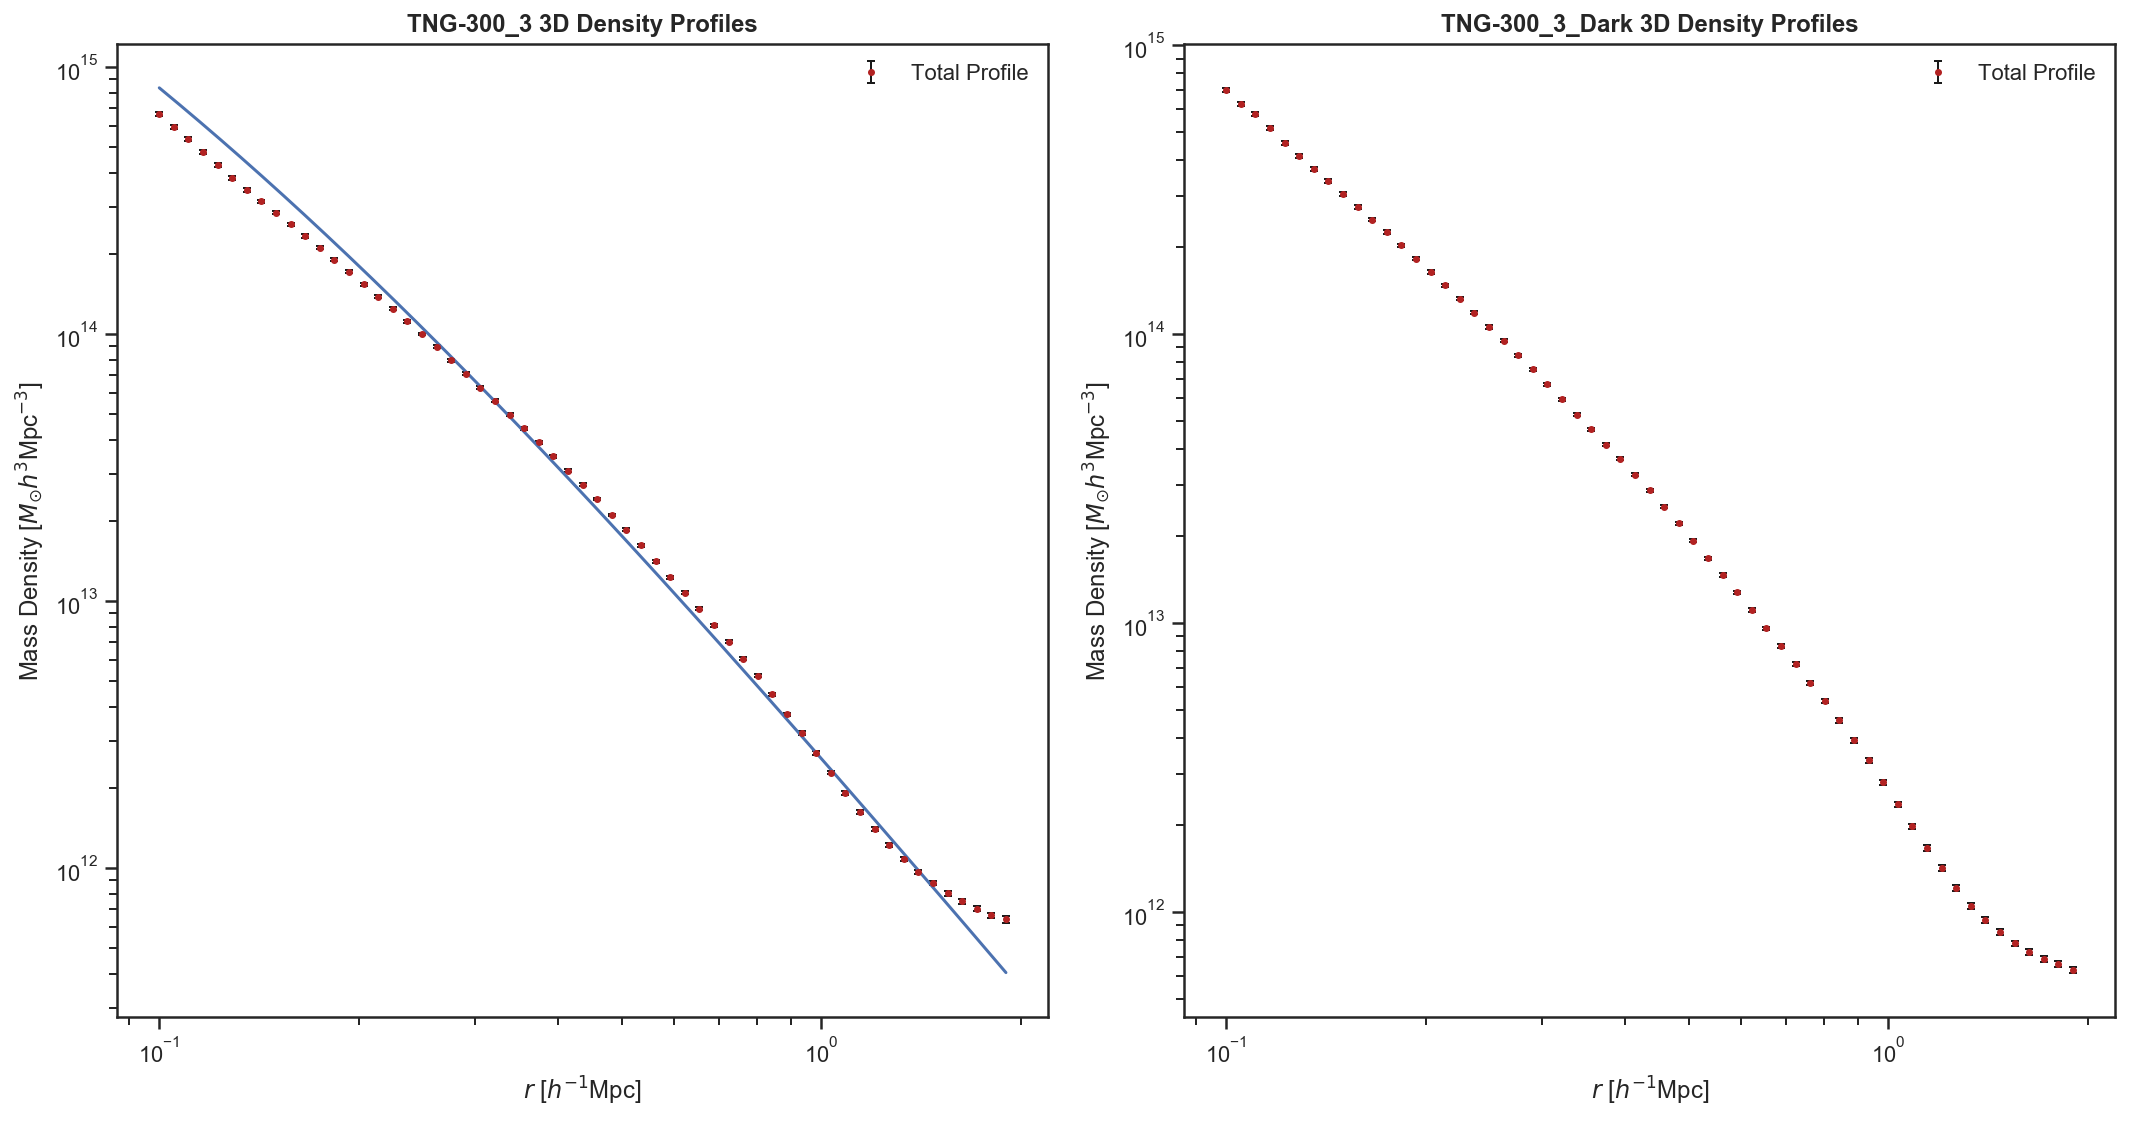

In [8]:
m_crit200_dark = np.mean(halo_grp_dark['Group_M_Crit200'][halo_indices_dark])
m_crit200 = np.mean(halo_grp['Group_M_Crit200'][halo_indices])

# Compute NFW Profile
c_crit200= concentration.concentration(m_crit200*10**10, mdef = '200c', z=redshift, model = 'bullock01')
p_nfw = profile_nfw.NFWProfile(M = m_crit200*10**10, 
                               c = c_crit200, z=redshift, mdef = '200c')

r_nfw = np.logspace(np.log10(np.min(averaged_r_tot)), 
                    np.log10(np.max(averaged_r_tot)), 1000)*(1000)
rho_nfw = p_nfw.density(r_nfw) # density in units of M_sun h^2/kpc^3
rho_nfw *= 1000**3/(H0.value/100) # Convert to M_sun/Mpc^3

"""---------------------------------------------------------------------------------"""
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
# plt.errorbar(averaged_r_dm, averaged_rho_dm, 
#              yerr=np.sqrt(var_dm), 
#              marker = '.', color = "darkblue", linestyle = "none",
#              markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
#              markeredgewidth=1, label="DM Particles")

# plt.errorbar(averaged_r_gas, averaged_rho_gas, 
#              yerr=np.sqrt(var_gas), 
#              marker = '.', color = "darkorange", linestyle = "none",
#              markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
#              markeredgewidth=1, label="Gas")

plt.errorbar(averaged_r_tot, averaged_rho_tot, 
             yerr=np.sqrt(np.diag(cov_tot)), 
             marker = '.', color = "firebrick", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Total Profile")

plt.plot(r_nfw/(1000), rho_nfw)


plt.title("TNG-300_3 3D Density Profiles", fontweight="bold")
plt.xlabel(r"$r$ [$h^{-1}$Mpc]")
plt.ylabel("Mass Density [$M_{\odot}h^3$Mpc$^{-3}$]")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")


plt.subplot(1,2,2)

plt.errorbar(averaged_r_tot_dark, averaged_rho_tot_dark, 
             yerr=np.sqrt(np.diag(cov_dark)), 
             marker = '.', color = "firebrick", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Total Profile")

plt.title("TNG-300_3_Dark 3D Density Profiles", fontweight="bold")
plt.xlabel(r"$r$ [$h^{-1}$Mpc]")
plt.ylabel("Mass Density [$M_{\odot}h^3$Mpc$^{-3}$]")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

plt.savefig("density_profiles.png", dpi=250)

### **Compare Profiles**

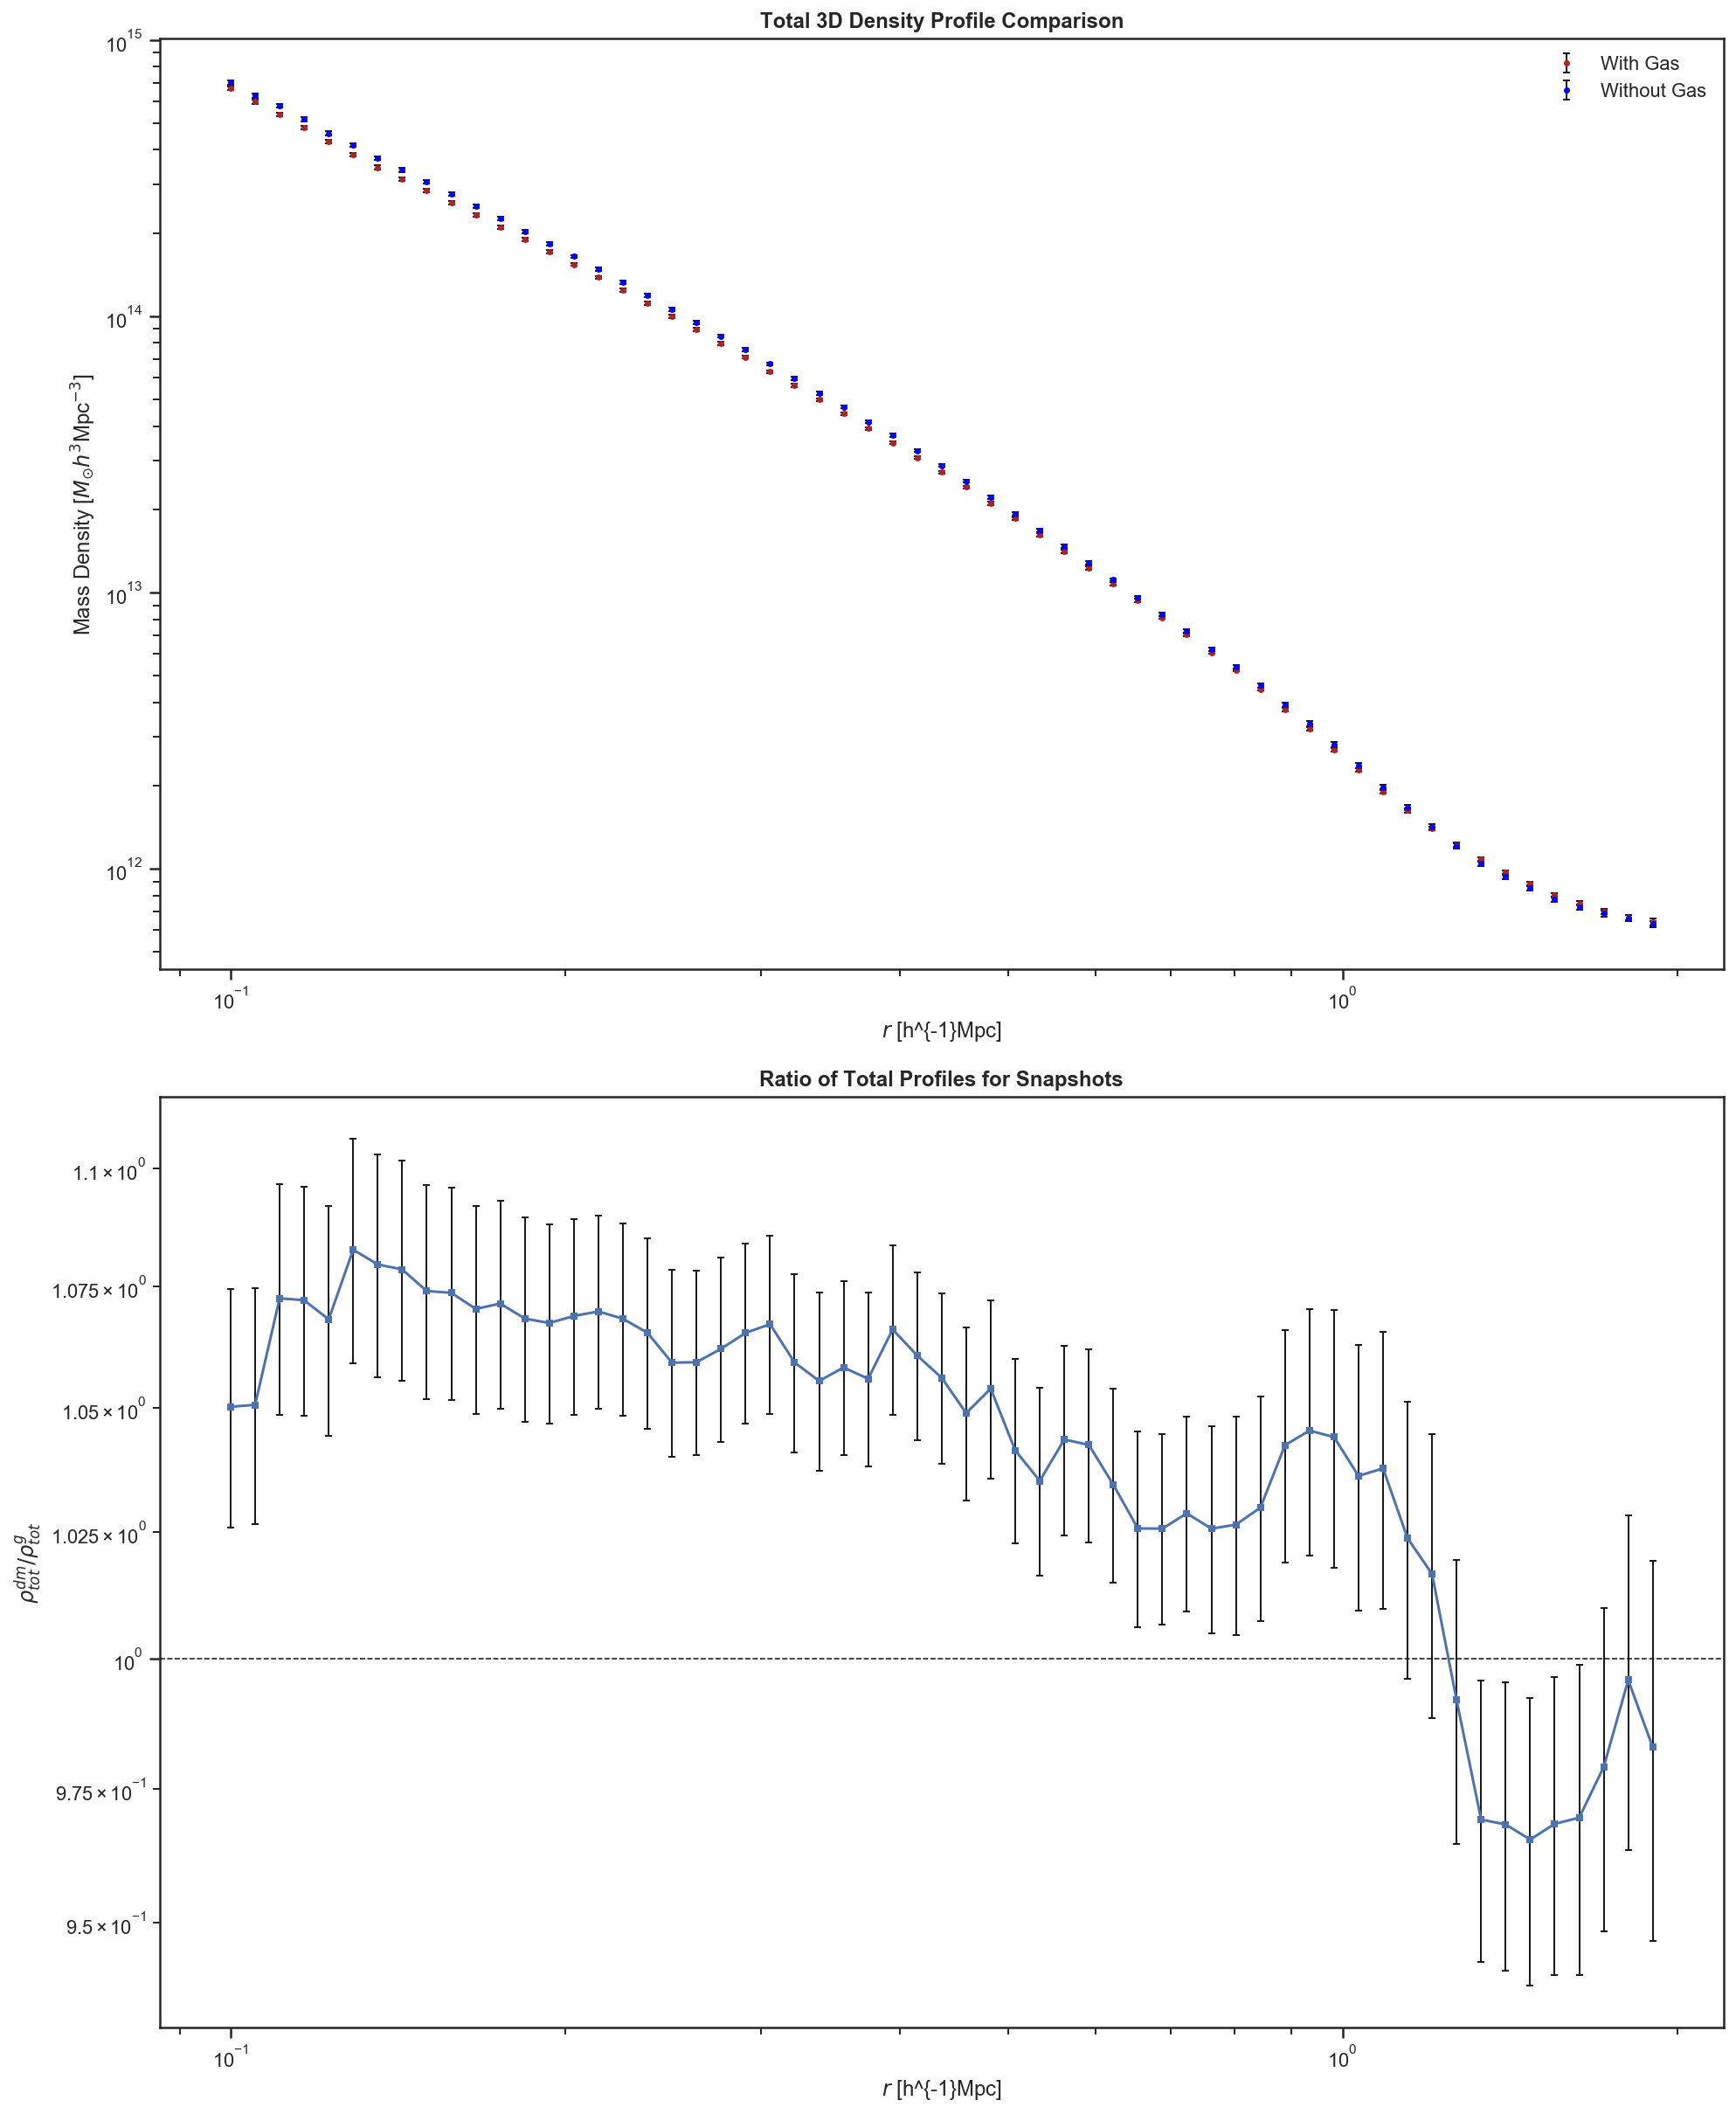

In [12]:
var_tot = np.diag(cov_tot)
var_tot_dark = np.diag(cov_dark)

plt.figure(figsize=(14, 17))

plt.subplot(2,1,1)

plt.errorbar(averaged_r_tot, averaged_rho_tot, 
             yerr=np.sqrt(var_tot), 
             marker = '.', color = "firebrick", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="With Gas")


plt.errorbar(averaged_r_tot_dark, averaged_rho_tot_dark, 
             yerr=np.sqrt(var_tot_dark), 
             marker = '.', color = "blue", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Without Gas")


plt.legend(frameon=False, loc="upper right")
plt.title("Total 3D Density Profile Comparison", fontweight="bold")
plt.xlabel(r"$r$ [h^{-1}Mpc]")
plt.ylabel("Mass Density [$M_{\odot}h^3$Mpc$^{-3}$]")
plt.xscale("log")
plt.yscale("log")


plt.subplot(2,1,2)

ind_1 = np.where(averaged_rho_tot != 0)
ind_2 = np.where(averaged_rho_tot_dark != 0)
ind_inter = np.intersect1d(ind_1, ind_2)

delta_rho_1 = np.sqrt(var_tot[ind_inter])/averaged_rho_tot[ind_inter]
delta_rho_2 = np.sqrt(var_tot_dark[ind_inter])/averaged_rho_tot_dark[ind_inter]


frac_error = np.sqrt(delta_rho_1**2+delta_rho_2**2)

ratio_error = frac_error*(averaged_rho_tot_dark[ind_inter])/(averaged_rho_tot[ind_inter])
plt.axhline(1, color="k", linestyle="--", linewidth = 0.8)

plt.errorbar(averaged_r_tot[ind_inter],
             (averaged_rho_tot_dark[ind_inter])/(averaged_rho_tot[ind_inter]), 
             yerr=ratio_error, markersize = 3, ecolor = 'k', 
             elinewidth = 1, capsize=2, marker='s',
             markeredgewidth=1)
plt.xscale("log")
plt.yscale("log")
plt.title("Ratio of Total Profiles for Snapshots", fontweight="bold")
plt.xlabel(r"$r/R_{200m}$")
plt.xlabel(r"$r$ [h^{-1}Mpc]")
plt.ylabel(r"$\rho_{tot}^{dm} / \rho_{tot}^{g}$")

plt.tight_layout()
plt.savefig("relative_profiles.png", dpi=250)

### **Make Phase Space Plots:**

Plot phase space diagrams of dark matter particles in all halos analyzed.

In [11]:
radial_vel = np.array([], dtype=float)
r = np.array([], dtype = float)

for halo_ind in halo_indices:
    
    halo_dm = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind,'dm')
    coord_ind = np.where(halo_indices==halo_ind)[0][0]
    halo_dm_pos = DM_COORDS[coord_ind]
    halo_dm_vel = DM_VELOC[coord_ind]
    halo_cm = halo_grp['GroupCM'][halo_ind]/(1000)
    dev = halo_dm_pos-halo_cm
    
    for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q

    r = np.append(r, np.linalg.norm(dev, axis=1))

    radial_vel = np.append(radial_vel, (halo_dm_vel*dev).sum(1))
    

radial_vel_dark = np.array([], dtype=float)
r_dark = np.array([], dtype = float)

for halo_ind in halo_indices_dark:
    
    halo_dm = il.snapshot.loadHalo(basePath_dark, snapshot_ind, halo_ind,'dm')
    
    coord_ind = np.where(halo_indices_dark==halo_ind)[0][0]
    halo_dm_pos = DM_COORDS_DARK[coord_ind]
    halo_vel = DM_VELOC_DARK[coord_ind]
    halo_cm = halo_grp_dark['GroupCM'][halo_ind]/(1000)
    dev = halo_dm_pos-halo_cm
    
    
    for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q

    r_dark = np.append(r_dark, np.linalg.norm(dev, axis=1))

    radial_vel_dark = np.append(radial_vel_dark, (halo_vel*dev).sum(1))

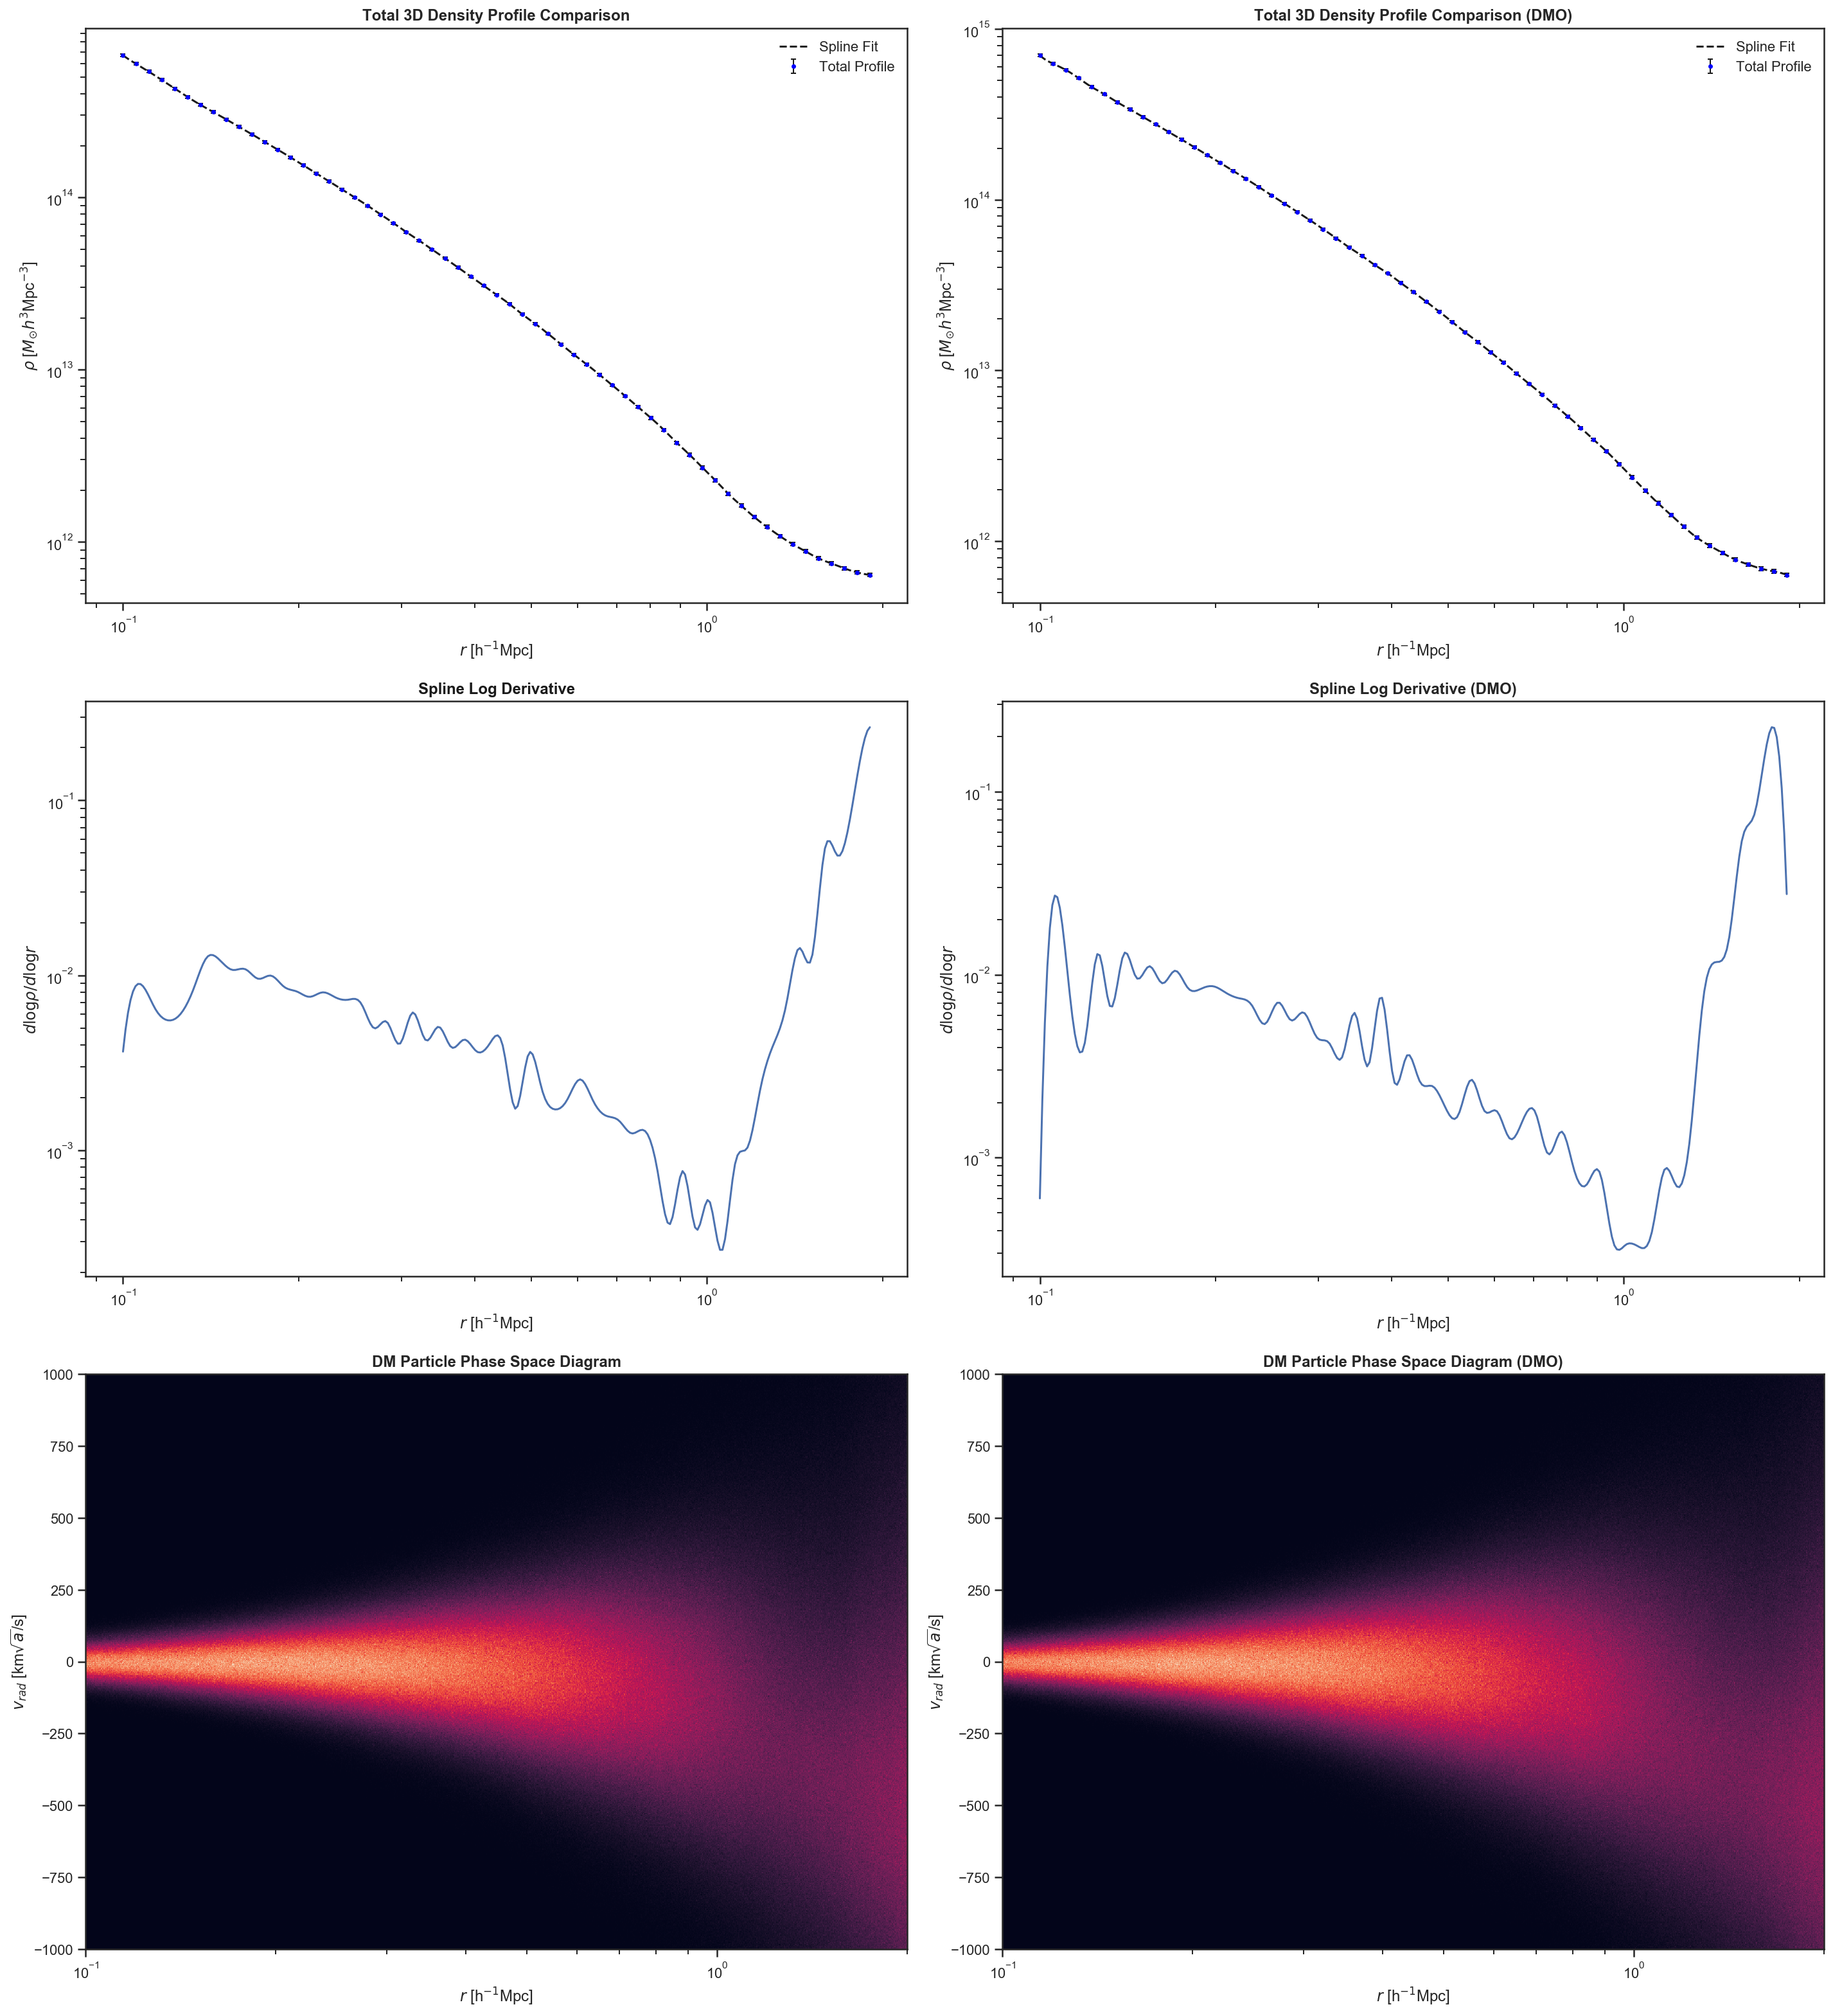

In [13]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(np.log10(averaged_r_tot), np.log10(averaged_rho_tot), k=4, s=0)
spl_dark = UnivariateSpline(np.log10(averaged_r_tot_dark), np.log10(averaged_rho_tot_dark), k=4, s=0)

r_thr = np.logspace(np.log10(np.min(averaged_r_tot)), np.log10(np.max(averaged_r_tot)), 300)
plt.figure(figsize=(20,22))

plt.subplot(3,2,1)
plt.errorbar(averaged_r_tot, averaged_rho_tot, 
             yerr=np.sqrt(var_tot_dark), 
             marker = '.', color = "blue", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Total Profile")
plt.plot(r_thr, 10**spl(np.log10(r_thr)), color="k", linestyle="--", 
         label="Spline Fit")
plt.legend(frameon=False, loc="upper right")
plt.title("Total 3D Density Profile Comparison", fontweight="bold")
plt.xlabel(r"$r$ [h$^{-1}$Mpc]")
plt.ylabel(r"$\rho$ [$M_{\odot}h^3$Mpc$^{-3}$]")
plt.xscale("log")
plt.yscale("log")

plt.subplot(3,2,2)
plt.errorbar(averaged_r_tot_dark, averaged_rho_tot_dark, 
             yerr=np.sqrt(var_tot_dark), 
             marker = '.', color = "blue", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="Total Profile")
plt.plot(r_thr, 10**spl_dark(np.log10(r_thr)), color="k", linestyle="--", 
         label="Spline Fit")
plt.legend(frameon=False, loc="upper right")
plt.title("Total 3D Density Profile Comparison (DMO)", fontweight="bold")
plt.xlabel(r"$r$ [h$^{-1}$Mpc]")
plt.ylabel(r"$\rho$ [$M_{\odot}h^3$Mpc$^{-3}$]")
plt.xscale("log")
plt.yscale("log")

plt.subplot(3,2,3)
plt.plot(r_thr, 10**spl.derivative()(np.log10(r_thr)))
plt.xscale("log")
plt.yscale("log")
plt.title("Spline Log Derivative", fontweight="bold", color="k")
plt.xlabel(r"$r$ [h$^{-1}$Mpc]")
plt.ylabel(r"$d\log \rho / d \log r$")

plt.subplot(3,2,4)
plt.plot(r_thr, 10**spl_dark.derivative()(np.log10(r_thr)))
plt.xscale("log")
plt.yscale("log")
plt.title("Spline Log Derivative (DMO)", fontweight="bold")
plt.xlabel(r"$r$ [h$^{-1}$Mpc]")
plt.ylabel(r"$d\log \rho / d \log r$")


vel_bins = np.linspace(np.min(radial_vel_dark), np.max(radial_vel_dark), 2000)
r_bin = np.logspace(-2, np.log10(2), 2000)

plt.subplot(3,2,5)
plt.hist2d(r, radial_vel, bins=(r_bin, vel_bins))
plt.xlim(0.1, 2) 
plt.ylim(-1000, 1000)

plt.title("DM Particle Phase Space Diagram", fontweight="bold")
plt.xlabel(r"$r$ [h$^{-1}$Mpc]")
plt.ylabel(r"$v_{rad}$ [km$\sqrt{a}$/s]")
plt.xscale("log")


plt.subplot(3,2,6)
plt.hist2d(r_dark, radial_vel_dark, bins=(r_bin, vel_bins))
plt.xlim(0.1, 2) 
plt.ylim(-1000, 1000)

plt.title("DM Particle Phase Space Diagram (DMO)", fontweight="bold")
plt.xlabel(r"$r$ [h$^{-1}$Mpc]")
plt.ylabel(r"$v_{rad}$ [km$\sqrt{a}$/s]")
plt.xscale("log")

plt.tight_layout()

plt.savefig("spline_fit_phase_plots.png", dpi=125)

##### **Fit Profiles:**

Fit profiles using MCMC. 3D density profile defined as
$$ \rho(r) =\rho_{inner}(r)f_{trans}+\rho_{out}(r)$$
where,
$$\rho_{inner}(r)=\rho_s\exp\bigg(-\frac{2}{\alpha}\bigg[\bigg(\frac{r}{r_s}\bigg)^\alpha-1 \bigg]\bigg)$$

$$f_{trans} = \bigg[1+\bigg(\frac{r}{r_t} \bigg)^\beta \bigg]^{-\gamma/\beta}$$

$$\rho_{outer}(r)=\rho_0\bigg(\frac{r}{r_0} \bigg)^{-s_e}$$

Fix $r_0 = 1.5$ Mpc/h since $r_0$ and $\rho_0$ are degenerate.

###### **Parameter Priors:**

<img src="DK_Priors.png">
<img src="DK_PRIORS_2.png">

In [26]:
dens_unit = 1*u.g/u.cm**3
conv_fac = dens_unit.to(u.M_sun/u.Mpc**3).value*h**3

In [55]:
r_0 = 1.5 # Fix r_0 to 1.5 Mpc/h



# Define halo profile model
def rho_DK14(theta, r):
    """
    Definition of halo profile model from Diemer Kravstov 2014
    r_s, r_t, r must all be in units of kpc/h
    """
    
    # alpha, beta, gamma, r_s, r_t, rho_s, rho_0, s_e = theta
    
    alpha, beta, gamma, r_s, r_t, rho_s, rho_0, s_e = initial
    rho_s, rho_0 = theta
    
    def rho_inner(r):
        exp_arg = -2/alpha*((r/r_s)**alpha-1)
        return rho_s*np.exp(exp_arg)

    def rho_outer(r):
        return rho_0*(r/r_0)**(-s_e)


    def f_trans(r):
        return (1+(r/r_t)**beta)**(-gamma/beta)
    
    
    return rho_inner(r)*f_trans(r)+rho_outer(r)


def log_like(theta, data):
    """
    Definition of log-likelihood using DK14 moel
    """
    r_data, rho_data, cov = data
    
    rho_thr = rho_DK14(theta, r_data)
    
    delta_vec = rho_data-rho_thr
    return -1/2*np.dot(delta_vec.T, np.dot(cov_tot, delta_vec))


# Define priors
def log_prior(theta):
    
    # alpha, beta, gamma, r_s, r_t, rho_s, rho_0, s_e = theta
    alpha, beta, gamma, r_s, r_t, rho_s, rho_0, s_e = initial
    rho_s, rho_0 = theta
    
    
    # Top hat prior on r_s, r_t, s_e
    r_s_check = (r_s > 0.1) & (r_s < 5)
    r_t_check = (r_t > 0.1) & (r_t < 5)
    s_e_check = (s_e > 1.0) & (s_e < 10)
    
#     rho_s_check = (rho_s/conv_fac > 0) & (rho_s/conv_fac < 10)
    rho_s_check = True
    rho_0_check = True
#     rho_0_check = (rho_0/conv_fac > 0) & (rho_0/conv_fac < 10)
 
    flat_prior_check = r_s_check & r_t_check & s_e_check & rho_s_check & rho_0_check
    
    if not flat_prior_check:
        return -np.inf
    
    # Gaussian prior on remaining params 
    alpha_prior = scipy.stats.norm(np.log(0.19), 0.1).logpdf(np.log(alpha))
    beta_prior = scipy.stats.norm(np.log(4.0), 0.2).logpdf(np.log(beta))
    gamma_prior = scipy.stats.norm(np.log(6.0), 0.2).logpdf(np.log(gamma))
    
    return alpha_prior+beta_prior+gamma_prior
    
    
def log_prob(theta, data):
    lp = log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp-log_like(theta, data)

In [ ]:
initial = [0.19, 6.0, 4.0, 3, 3, 5*conv_fac, 5*conv_fac, 5]
guess = [10**20, 10**20]

r_fit = averaged_r_tot
rho_fit = averaged_rho_tot
err_fit = np.sqrt(np.diag(cov_tot))

data = [r_fit, rho_fit, cov_tot]
res = scipy.optimize.minimize(log_prob, guess, data, method="Nelder-Mead")

In [65]:
res.x

array([2.29831262e+12, 4.80467364e+08])

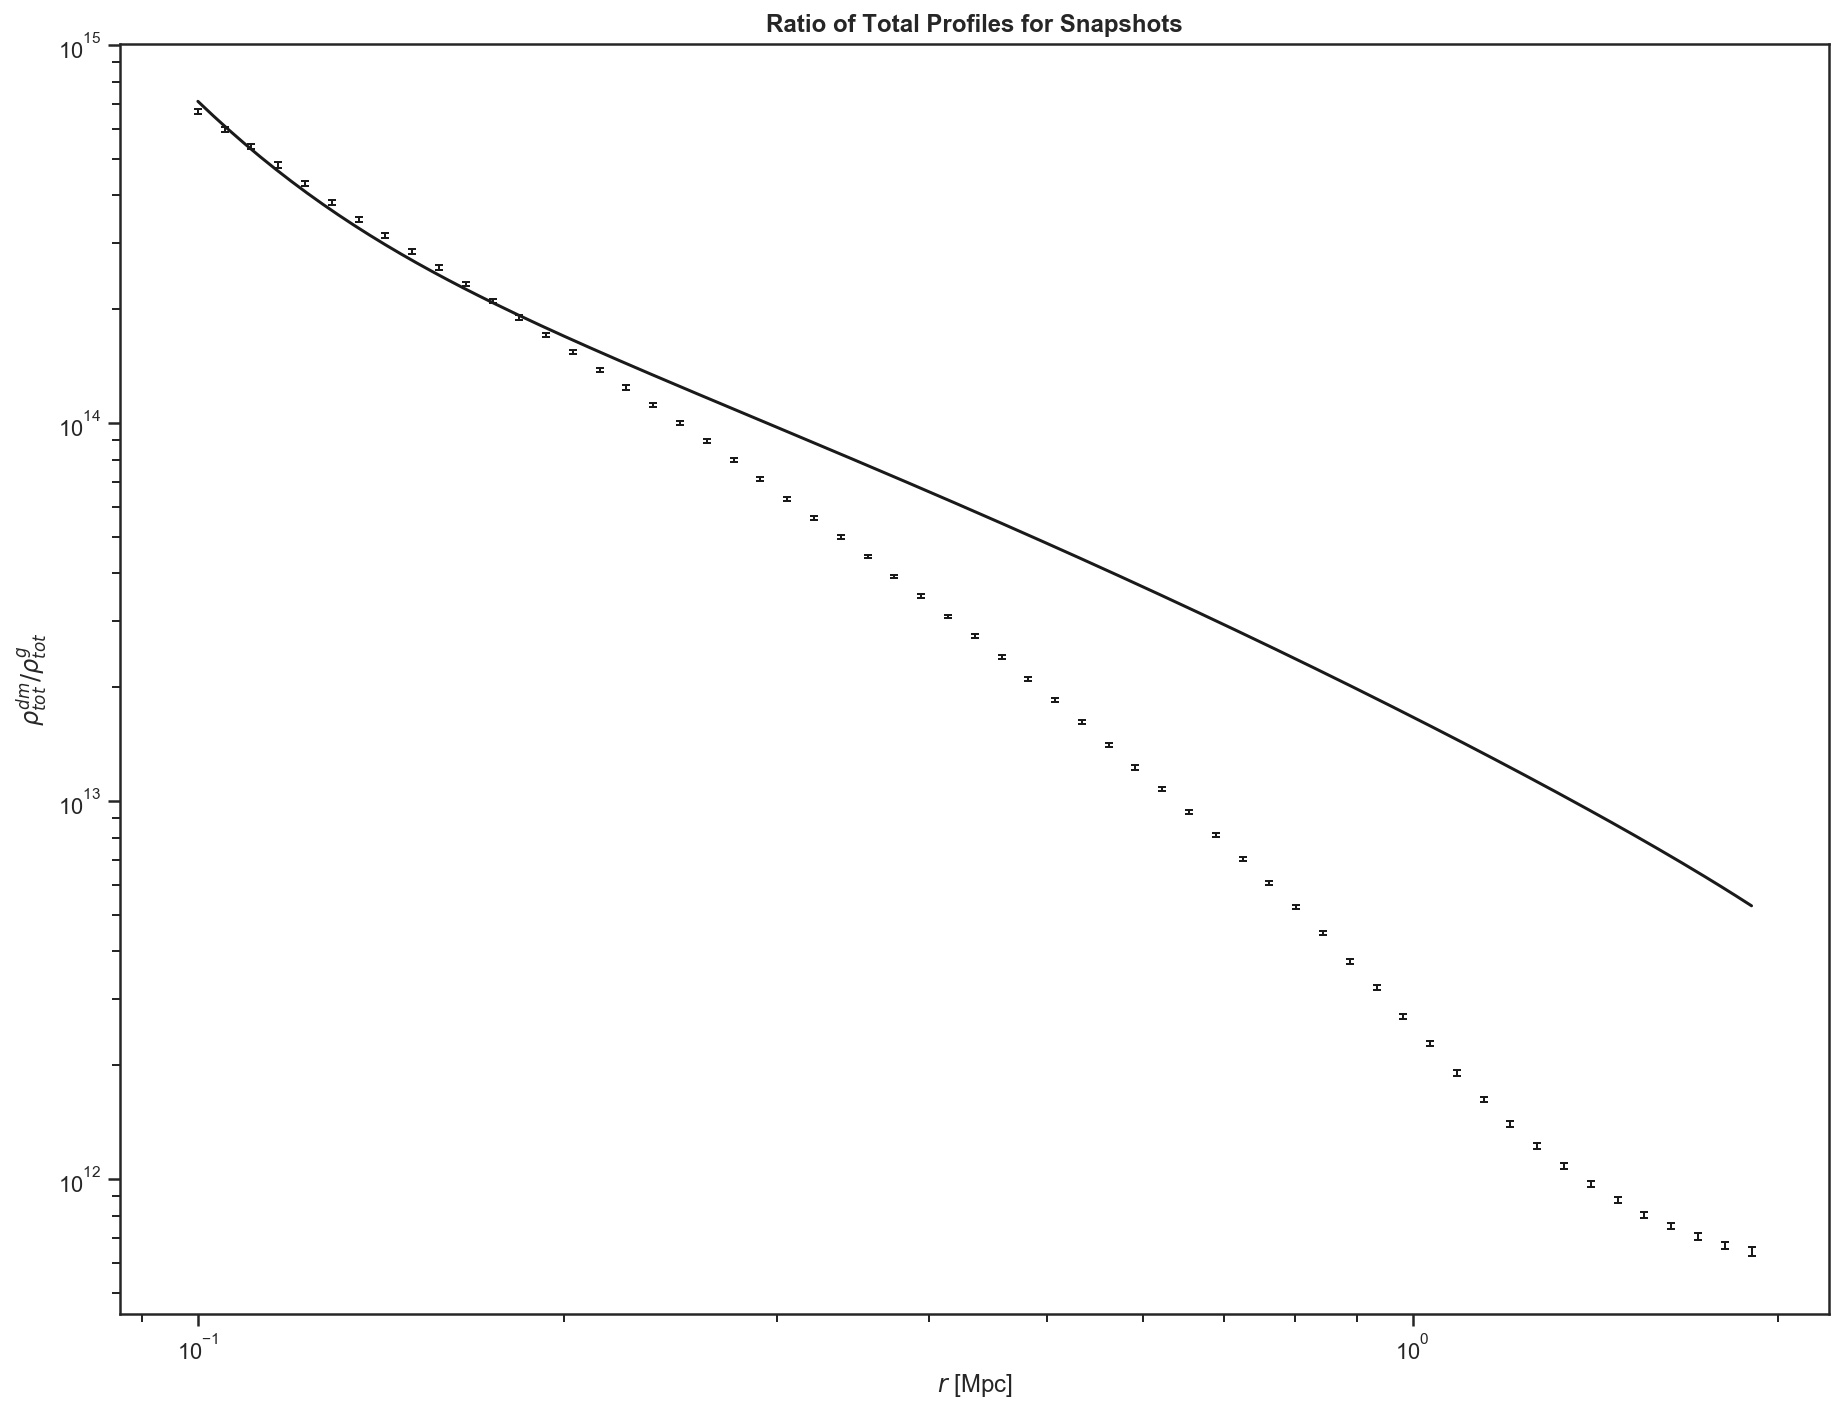

In [64]:

r_thr = np.logspace(np.log10(np.min(r_fit)), np.log10(np.max(r_fit)), 200)
rho_thr = rho_DK14(theta_guess, r_thr)

plt.figure(figsize=(13,10))
plt.errorbar(r_fit, rho_fit, err_fit, markersize = 3, ecolor = 'k', 
             elinewidth = 1, capsize=2, linewidth=0)
plt.plot(r_thr, rho_thr, color="k")
plt.xscale("log")
plt.yscale("log")

plt.title("Ratio of Total Profiles for Snapshots", fontweight="bold")
plt.xlabel(r"$r$ [Mpc]")

plt.ylabel(r"$\rho_{tot}^{dm} / \rho_{tot}^{g}$")

plt.tight_layout()

In [43]:
# Run MCMC to fit data
ind_tot = np.where(averaged_rho_tot != 0)
data = (averaged_r_tot[ind_tot], averaged_rho_tot[ind_tot], np.sqrt(var_tot)[ind_tot])

# initial = [alpha, beta, gamma, r_s, r_t, rho_s, rho_0, s_e]
initial = [0.19, 6.0, 4.0, 3, 3, 5*conv_fac, 5*conv_fac, 5]


ndim = len(initial)
nwalkers=500
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
niter = 1000

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,log_prob,data)

Running burn-in...


ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

In [ ]:
samples = sampler.flatchain
labels = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$r_s$', 
          r'$r_t$', r'$rho_s$', r'$rho_0$', r'$s_e$']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [ ]:
plt.subplot(2,1,1)

plt.errorbar(averaged_r_tot, averaged_rho_tot, 
             yerr=np.sqrt(var_tot), 
             marker = '.', color = "firebrick", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label="With Gas")

In [ ]:
best_fit = samples[np.argmax(sampler.flatlnprobability)]

r = np.linspace(np.min(averaged_r_tot[ind_tot]), np.max(averaged_r_tot[ind_tot]), 1000)

rho_tot_thr = rho_tot_model(best_fit, r)

### **Phase Space Plots**